In [1]:
import os

from keras.datasets import imdb
import torch.nn as nn
import torch
from torch.nn.utils.rnn import pad_sequence
import warnings
warnings.filterwarnings("ignore")

In [2]:
def load_data(device='cpu'):
    # 加载 IMDB 数据集
    (train_data, train_labels), (test_data, test_labels) = imdb.load_data(num_words=10000)
    
    # 统一长度，不足的填充 0
    max_len = 200
    train_data = [torch.tensor(seq)[:max_len] for seq in train_data]
    test_data = [torch.tensor(seq)[:max_len] for seq in test_data]
    
    # 填充数据
    train_data = pad_sequence(train_data, batch_first=True)
    test_data = pad_sequence(test_data, batch_first=True)
    
    # 转换为 pytorch tensor
    train_labels = torch.tensor(train_labels, dtype=torch.float32, device=device)
    test_labels = torch.tensor(test_labels, dtype=torch.float32, device=device)
    train_data = torch.tensor(train_data, dtype=torch.long, device=device)
    test_data = torch.tensor(test_data, dtype=torch.long, device=device)
    
    # 查看数据集大小
    print(f'训练集大小: {len(train_data)}')
    print(f'测试集大小: {len(test_data)}')
    print("train labels shape: ", train_labels.shape)
    print("test labels shape: ", test_labels.shape)
    print("train data shape: ", train_data.shape)
    print("test data shape: ", test_data.shape)

    return train_data, train_labels, test_data, test_labels

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_data, train_labels, test_data, test_labels = load_data(device=device)
print(train_data[0])

训练集大小: 25000
测试集大小: 25000
train labels shape:  torch.Size([25000])
test labels shape:  torch.Size([25000])
train data shape:  torch.Size([25000, 200])
test data shape:  torch.Size([25000, 200])
tensor([   1,   14,   22,   16,   43,  530,  973, 1622, 1385,   65,  458, 4468,
          66, 3941,    4,  173,   36,  256,    5,   25,  100,   43,  838,  112,
          50,  670,    2,    9,   35,  480,  284,    5,  150,    4,  172,  112,
         167,    2,  336,  385,   39,    4,  172, 4536, 1111,   17,  546,   38,
          13,  447,    4,  192,   50,   16,    6,  147, 2025,   19,   14,   22,
           4, 1920, 4613,  469,    4,   22,   71,   87,   12,   16,   43,  530,
          38,   76,   15,   13, 1247,    4,   22,   17,  515,   17,   12,   16,
         626,   18,    2,    5,   62,  386,   12,    8,  316,    8,  106,    5,
           4, 2223, 5244,   16,  480,   66, 3785,   33,    4,  130,   12,   16,
          38,  619,    5,   25,  124,   51,   36,  135,   48,   25, 1415,   33,
      

In [4]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(LSTMModel, self).__init__()
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # LSTM 层
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        lstm_out, _ = self.lstm(x)
        out = self.dropout(lstm_out[:, -1, :])  # 取最后一层输出
        out = self.fc(out)
        return out


In [5]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout):
        super(RNNModel, self).__init__()
        # 词嵌入层
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        # RNN 层
        self.rnn = nn.RNN(embedding_dim, hidden_dim, num_layers=n_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = self.embedding(x)
        rnn_out, _ = self.rnn(x)
        out = self.dropout(rnn_out[:, -1, :])  # 取最后一层输出
        out = self.fc(out)
        return out

In [6]:
from torch.utils.data import Dataset, DataLoader
from prefetch_generator import BackgroundGenerator

class IMDBDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

class DataLoaderX(DataLoader):
    def __iter__(self):
        return BackgroundGenerator(super().__iter__(), max_prefetch=32)

In [7]:
def train_model(model, train_data, train_labels, criterion, optimizer, num_epochs=5, batch_size=128):
    # 创建数据集和数据加载器
    dataset = IMDBDataset(train_data, train_labels)
    train_loader = DataLoaderX(dataset, batch_size=batch_size, shuffle=True)

    model.train()
    correct = 0
    total = 0
    train_acc = []
    train_loss = []
    for epoch in range(num_epochs):
        cur_loss = []
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            correct += (torch.round(torch.sigmoid(outputs)).squeeze() == labels).sum().item()
            total += labels.size(0)
            loss = criterion(outputs, labels.unsqueeze(1))  # 需要调整标签形状
            loss.backward()
            optimizer.step()
            cur_loss.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {sum(cur_loss)/len(cur_loss):.4f}, Accuracy: {correct/total:.4f}')
        train_acc.append(correct / total)
        train_loss.append(sum(cur_loss) / len(cur_loss))
    return train_acc, train_loss

def evaluate_model(model, test_data, test_labels, batch_size=32):
    dataset = IMDBDataset(test_data, test_labels)
    test_loader = DataLoaderX(dataset, batch_size=batch_size, shuffle=False)

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            predictions = torch.round(torch.sigmoid(outputs))
            correct += (predictions.squeeze() == labels).sum().item()
            total += labels.size(0)
    accuracy = correct / total
    print(f'Accuracy: {accuracy:.4f}')

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using {device} device')

# 设置超参数
vocab_size = 10000
embedding_dim = 32
hidden_dim = 64
output_dim = 1
n_layers = 3
dropout = 0.5
num_epochs = 100
learning_rate = 0.01
batch_size = 256
max_len = 200
res = {}

Using cuda device


In [9]:
# LSTM 模型训练与评估

# 创建模型、优化器和损失函数
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
lstm_model = lstm_model.to(device)
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)
criterion = nn.BCEWithLogitsLoss()

# 训练和评估模型
acc, loss = train_model(lstm_model, train_data, train_labels, criterion, optimizer, num_epochs, batch_size=256)
evaluate_model(lstm_model, test_data, test_labels, batch_size)
res['LSTM'] = [acc, loss]
# 保存模型
torch.save(lstm_model.state_dict(), 'data' + os.sep +'lstm_model.pth')

Epoch [1/100], Loss: 0.6942, Accuracy: 0.5037
Epoch [2/100], Loss: 0.6935, Accuracy: 0.5042
Epoch [3/100], Loss: 0.6935, Accuracy: 0.5019
Epoch [4/100], Loss: 0.6933, Accuracy: 0.5002
Epoch [5/100], Loss: 0.6933, Accuracy: 0.5006
Epoch [6/100], Loss: 0.6911, Accuracy: 0.5038
Epoch [7/100], Loss: 0.6867, Accuracy: 0.5074
Epoch [8/100], Loss: 0.6425, Accuracy: 0.5236
Epoch [9/100], Loss: 0.5059, Accuracy: 0.5508
Epoch [10/100], Loss: 0.3689, Accuracy: 0.5806
Epoch [11/100], Loss: 0.2960, Accuracy: 0.6082
Epoch [12/100], Loss: 0.2467, Accuracy: 0.6332
Epoch [13/100], Loss: 0.2121, Accuracy: 0.6556
Epoch [14/100], Loss: 0.1790, Accuracy: 0.6760
Epoch [15/100], Loss: 0.1609, Accuracy: 0.6941
Epoch [16/100], Loss: 0.1372, Accuracy: 0.7106
Epoch [17/100], Loss: 0.1230, Accuracy: 0.7254
Epoch [18/100], Loss: 0.1140, Accuracy: 0.7388
Epoch [19/100], Loss: 0.0963, Accuracy: 0.7511
Epoch [20/100], Loss: 0.0841, Accuracy: 0.7623
Epoch [21/100], Loss: 0.0801, Accuracy: 0.7726
Epoch [22/100], Loss: 

In [10]:
# RNN 模型训练与评估

# 创建模型、优化器和损失函数
rnn_model = RNNModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
rnn_model = rnn_model.to(device)
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# 训练和评估模型
acc, loss = train_model(rnn_model, train_data, train_labels, criterion, optimizer, num_epochs, batch_size=512)
evaluate_model(rnn_model, test_data, test_labels, batch_size)
res['RNN'] = [acc, loss]

Epoch [1/100], Loss: 0.6977, Accuracy: 0.5042
Epoch [2/100], Loss: 0.6957, Accuracy: 0.5038
Epoch [3/100], Loss: 0.6951, Accuracy: 0.5036
Epoch [4/100], Loss: 0.6941, Accuracy: 0.5045
Epoch [5/100], Loss: 0.6931, Accuracy: 0.5060
Epoch [6/100], Loss: 0.6928, Accuracy: 0.5063
Epoch [7/100], Loss: 0.6921, Accuracy: 0.5078
Epoch [8/100], Loss: 0.6910, Accuracy: 0.5094
Epoch [9/100], Loss: 0.6898, Accuracy: 0.5117
Epoch [10/100], Loss: 0.6885, Accuracy: 0.5134
Epoch [11/100], Loss: 0.6862, Accuracy: 0.5156
Epoch [12/100], Loss: 0.6834, Accuracy: 0.5180
Epoch [13/100], Loss: 0.6791, Accuracy: 0.5203
Epoch [14/100], Loss: 0.6746, Accuracy: 0.5231
Epoch [15/100], Loss: 0.6690, Accuracy: 0.5260
Epoch [16/100], Loss: 0.6645, Accuracy: 0.5288
Epoch [17/100], Loss: 0.6596, Accuracy: 0.5321
Epoch [18/100], Loss: 0.6530, Accuracy: 0.5353
Epoch [19/100], Loss: 0.6449, Accuracy: 0.5387
Epoch [20/100], Loss: 0.6345, Accuracy: 0.5423
Epoch [21/100], Loss: 0.6428, Accuracy: 0.5453
Epoch [22/100], Loss: 

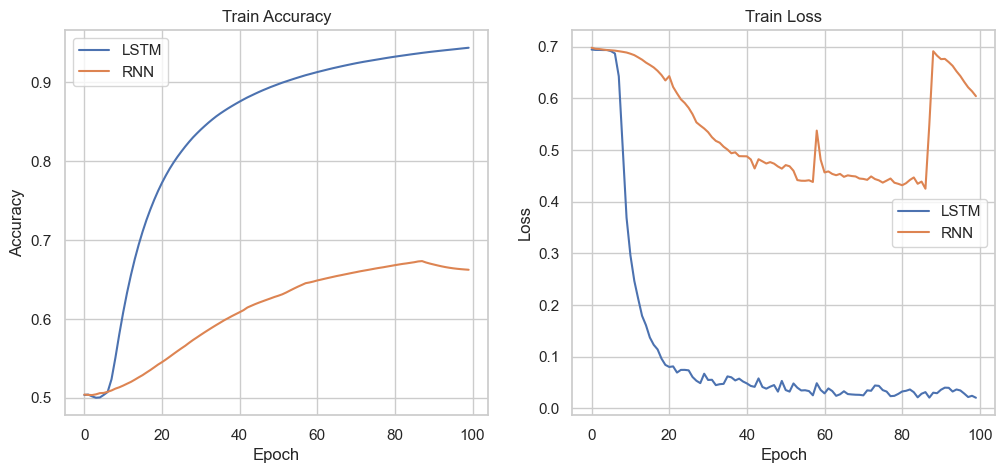

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))
sns.set_theme(style='whitegrid')
plt.subplot(1, 2, 1)
for model_name, (acc, _) in res.items():
    sns.lineplot(x=range(num_epochs), y=acc, label=model_name)
plt.title('Train Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
for model_name, (_, loss) in res.items():
    sns.lineplot(x=range(num_epochs), y=loss, label=model_name)
plt.title('Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [12]:
def index2word(sentence_index):
    start_char = 1
    oov_char = 2
    index_from = 3
    
    word_index = imdb.get_word_index()
    inverted_word_index = dict(
        (i + index_from, word) for (word, i) in word_index.items()
    )
    
    inverted_word_index[start_char] = "[START]"
    inverted_word_index[oov_char] = "[OOV]"
    inverted_word_index[0] = "[PAD]"
    
    decoded_sequence = " ".join(inverted_word_index[i] for i in sentence_index)
    return decoded_sequence

def word2index(sentence_word):
    start_char = 1
    oov_char = 2
    index_from = 3
    
    word_index = imdb.get_word_index()
    inverted_word_index = dict(
        (word, i + index_from) for (word, i) in word_index.items()
    )
    inverted_word_index["[START]"] = start_char
    inverted_word_index["[OOV]"] = oov_char
    inverted_word_index["[PAD]"] = 0
    
    sentence_index = [inverted_word_index.get(word, 0) for word in sentence_word]
    return sentence_index

# 使用句子测试
def predict_sentiment(sentence, model, vocab_size=200, max_len=200, device='cpu'):
    # 预处理句子
    sentence = sentence.lower().split(" ")
    sentence = word2index(sentence)
    sentence = torch.tensor(sentence).to(device)
    # 使用"[PAD]"填充
    if len(sentence) < max_len:
        sentence = torch.cat([sentence, torch.zeros(max_len-len(sentence), dtype=torch.long, device=device)])
    else:
        sentence = sentence[:max_len]
    sentence = pad_sequence([sentence], batch_first=True)
    
    # 预测
    model.eval()
    with torch.no_grad():
        output = model(sentence)
        prediction = torch.round(torch.sigmoid(output)).item()
    return prediction

print("Sample sentence: ")
print(index2word(test_data[0].cpu().numpy()))

Sample sentence: 
[START] please give this one a miss br br [OOV] [OOV] and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite [OOV] so all you madison fans give this a miss [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PA

In [15]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
lstm_model = LSTMModel(vocab_size, embedding_dim, hidden_dim, output_dim, n_layers, dropout)
lstm_model = lstm_model.to(device)
lstm_model.load_state_dict(torch.load('data' + os.sep + 'lstm_model.pth', map_location=device))

sentence = '[START] this movie is great I love it It is the best movie ever [OOV]'
prediction = predict_sentiment(sentence, lstm_model, device=device)
print(f'Sentence: {sentence}, Prediction: {"Positive" if prediction == 1 else "Negative"}')

sentence = '[START] It is terrible [OOV]'
prediction = predict_sentiment(sentence, lstm_model, device=device)
print(f'Sentence: {sentence}, Prediction: {"Positive" if prediction == 1 else "Negative"}')

sentence = '[START] I love this movie [OOV]'
prediction = predict_sentiment(sentence, lstm_model, device=device)
print(f'Sentence: {sentence}, Prediction: {"Positive" if prediction == 1 else "Negative"}')

sentence = '[START] It is not good enough [OOV]'
prediction = predict_sentiment(sentence, lstm_model, device=device)
print(f'Sentence: {sentence}, Prediction: {"Positive" if prediction == 1 else "Negative"}')

sentence = '[START] the director is a big fool [OOV]'
prediction = predict_sentiment(sentence, lstm_model, device=device)
print(f'Sentence: {sentence}, Prediction: {"Positive" if prediction == 1 else "Negative"}')

Sentence: [START] this movie is great I love it It is the best movie ever [OOV], Prediction: Positive
Sentence: [START] It is terrible [OOV], Prediction: Negative
Sentence: [START] I love this movie [OOV], Prediction: Positive
Sentence: [START] It is not good enough [OOV], Prediction: Negative
Sentence: [START] the director is a big fool [OOV], Prediction: Negative
